In [2]:
%matplotlib widget
import niscope as ni

# Uscita trigger dal signal generator: Pulse Sync

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import sys
sys.path.insert(1, '..\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')

import RS_SMA100B
from Card_Class import *

In [21]:
ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

# parameters for the Signal Generator
f_min           = 8.5718125e9 - 20e6                                 # tryout value
f_max           = 8.5718125e9 + 20e6                                 # tryout value
pulse_freq      = np.arange(f_min, f_max, 1e9)          # Set range of frequency of the signal to send to the resonator
amplitude       = -10                           # Set the amplitude of the signal in dBm
sample_rate     = 250e6 # Maximum Value: 250.0e6
pulse_width     = 5                                 # 2 microsec
pulse_delay     = 5
pulse_period    = 1000  


sGen.reset()
sGen.clear()
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('AUTO')
sGen.RF_freq(104e6)


# # parameters for the Acquisition Card
# pxie.voltage_range      = 2.0
# pxie.coupling           = 'AC' # or DC????
# pxie.num_pts            = 1000
# pxie.num_records        = 1
# pxie.ref_position       = 0
# pxie.sample_rate        = sample_rate # Maximum Value: 250.0e6

# pxie.open()


# Turn ON the modulation of the Signal Generator
sGen.pul_state(1)
sGen.RF_state(1)

SMA100B: Connection successful!
5170R: Available communication!


In [22]:
with ni.Session("PXI1Slot3") as session: # Name of the device
    session.channels[0].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC)
    session.channels[1].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC)
    session.configure_horizontal_timing(
        min_sample_rate     = 250e6, 
        min_num_pts         = int(1000), 
        ref_position        = 0, 
        num_records         = 1, 
        enforce_realtime    = True
        )

    session.configure_trigger_digital(
        trigger_source      = 'VAL_PFI_0', 
        slope               = ni.TriggerSlope.POSITIVE, 
        holdoff             = 0, 
        delay               = 0
        )

    with session.initiate():
        sGen.pul_exe_sing_trig()
        waveforms = session.channels[0, 1].fetch()
    for wfm in waveforms:
        print('Channel {0}, record {1} samples acquired: {2:,}\n'.format(wfm.channel, wfm.record, len(wfm.samples)))


Channel 0, record 0 samples acquired: 1,000

Channel 1, record 0 samples acquired: 1,000



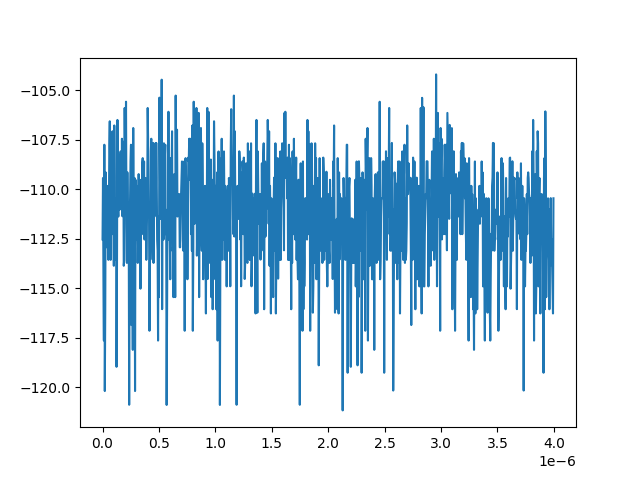

In [23]:
a = waveforms[0].samples.tolist()
b = waveforms[1].samples.tolist()
plt.figure()
plt.plot(np.arange(len(a))/250e6, 20*np.log10(np.array(a)**2+np.array(b)**2))